# NHL player Shooting Hand Predictor
- author: Jay Mangat, Michael Gelfand, Dominic Lam, Yunke Zhang

In [1]:
import pandas as pd
import altair as alt
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import ConfusionMatrixDisplay 

## Summary
Is there a correlation between a National Hockey League (NHL) player's height/weight and their shooting hand? We endeavoured to solve this using a logisitic regression model and a database of NHL players from the 1999 season till the 2023 season. After creating our model, we found there to be a weak correlation between these items as our model scored at 0.51 which is barely better than guessing. 

## Introduction
The relationship between a player's various physical attributes can provide valuable insights to their performance within that sport. This report explores whether the shooting hand (left or right) of NHL players can be predicted based on their height and weight. To answer this question we used a logistic regression model. The model estimates the probability that a given height and weight corresponds to whether a player is left handed or right handed.

If the report provides a solid analysis, this information could help teams get more right handed shooters as they have a slight advantages over left handed shooters. In this report, we show the acquisition of the data, its preprocessing, creating and training a sklearn logisitic regression model, and our results. By analyzing patterns in the data, we aim to assess the strength of the relationship between a player's height and weight and their preferred shooting hand.

# Methods

## Data

The data set for this shot predictor project is of National Hockey League (NHL) roster information created by the Data Science Learning Community (Data Science Learning Community, 2024) for the Tidy Tuesday project repository. The data here was created using the NHL's API and loaded on to the Tidy Tuesday repository [here](https://github.com/rfordatascience/tidytuesday/blob/master/data/2024/2024-01-09/nhl_rosters.csv). Each row in the data set contains information about all hockey players on every team from the 1917-1918 season to the 2023-2024 season. The rows include information such as name, birth date, and body dimensions. 

## Analysis

A logistic regression classifier was used to create a model which will predict whether a hockey player shoots left or right based on their height and weight. As the team is only interested in those two specific columns for predicting shooting side, all other columns were dropped. The test set was created using 30% of the records from the initial data set, leaving 70% of records for model training. For this analysis, the class weight parameter was set to balanced to ensure that the classes are equal and to avoid class imbalance. Data cleanup was done to remove duplicate records and null values and [reprocessing was done on the height and weight input features to standardize them. To perform the analysis, the Python programming language (Python Software Foundation, n.d.) was used along with the following packages: Pandas (The pandas development team, n.d.), Altair (VanderPlas et al., n.d.), and scikit-learn (Pedregosa et al., 2011).

# Results

Exploratory data analysis was done to visual class distributions for the training data. From this we can see whether there are large class imbalances which could negatively impact the true accuracy of the model.

In [2]:
alt.data_transformers.enable("vegafusion")

# Read in dataset from github 
rosters = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/refs/heads/master/data/2024/2024-01-09/nhl_rosters.csv")
rosters.to_csv('data/nhl_rosters.csv')

In [3]:
# Data wrangling and cleanup
# Drop NA records
rosters_clean = rosters[["weight_in_kilograms","height_in_centimeters","shoots_catches"]]
rosters_clean = rosters_clean.dropna()

# Convert target column to binary with shoots left as 1 and shoots right as 0
pd.set_option('future.no_silent_downcasting', True)
rosters_clean["shoots_left"] = rosters_clean["shoots_catches"].replace({'L': True, 'R': False}).astype(bool)
rosters_clean = rosters_clean.drop("shoots_catches", axis = 1)

In [4]:
# Split into train and test
train_df, test_df = train_test_split(rosters_clean, test_size=0.3, random_state=123)

In [5]:
# Examine the data set for exploratory data analysis
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38200 entries, 22925 to 53045
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   weight_in_kilograms    38200 non-null  float64
 1   height_in_centimeters  38200 non-null  float64
 2   shoots_left            38200 non-null  bool   
dtypes: bool(1), float64(2)
memory usage: 932.6 KB


In [6]:
# Get information about numeric features
train_df.describe()

,weight_in_kilograms,height_in_centimeters
count,38200.000000,38200.000000
mean,88.651545,183.881806
std,8.231288,5.917253
min,57.000000,160.000000
25%,84.000000,180.000000
50%,88.000000,183.000000
75%,94.000000,188.000000
max,120.000000,206.000000


In [7]:
# View first five records of dataset 
train_df.head()

,weight_in_kilograms,height_in_centimeters,shoots_left
22925,87.0,183.0,True
18712,92.0,188.0,False
1702,88.0,185.0,True
8026,84.0,180.0,False
6122,93.0,188.0,False


In [29]:
# Perform exploratory data analysis
# alt.Chart(train_df).mark_bar().encode(
#     alt.X(alt.repeat("row")).type('quantitative').bin(),
#     alt.Y("count()"),
#     alt.Fill("shoots_left")
# ).facet(
#     "shoots_left",
# ).repeat(
#     row=['weight_in_kilograms', 'height_in_centimeters'],
# )

# Weight distribution bar chart
weight_chart = alt.Chart(train_df).mark_bar().encode(
    alt.X("weight_in_kilograms:Q", title="Weight (kg)").bin(),
    alt.Y("count()", title="Number of Players"),
    alt.Color("shoots_left", title="Shooting Hand)")
).facet(
    "shoots_left",
).properties(
    title="Distribution of Player Weight by Shooting Hand"
)

# Height distribution bar chart
height_chart = alt.Chart(train_df).mark_bar().encode(
    alt.X("height_in_centimeters:Q", title="Height (cm)").bin(),
    alt.Y("count()", title="Number of Players"),
    alt.Color("shoots_left", title="Shooting Hand (Left = 1, Right = 0)")
).facet(
    "shoots_left",
).properties(
    title="Distribution of Player Height by Shooting Hand"
)

combined_chart = alt.vconcat(weight_chart, height_chart)
combined_chart

alt.VConcatChart(...)

Figure 1. Comparison of count distributions of input features for players that shoot left or right.

In [9]:
# Lists of feature names
numeric_features = ["weight_in_kilograms","height_in_centimeters"]

# Create the column transformer
preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),  # scaling on numeric features
)

In [10]:
# Create X and y data frames for train and test data
X_train = train_df.drop(columns=["shoots_left"])
X_test = test_df.drop(columns=["shoots_left"])
y_train = train_df["shoots_left"]
y_test = test_df["shoots_left"]

In [11]:
# Create the logistic regression model pipeline and fit on the training data
logreg = make_pipeline(preprocessor, LogisticRegression(random_state=123, class_weight="balanced"))
logreg.fit(X_train, y_train);

In [12]:
# Score the logistic regression model on the test data
logreg.score(X_test, y_test)

0.5155753725873442

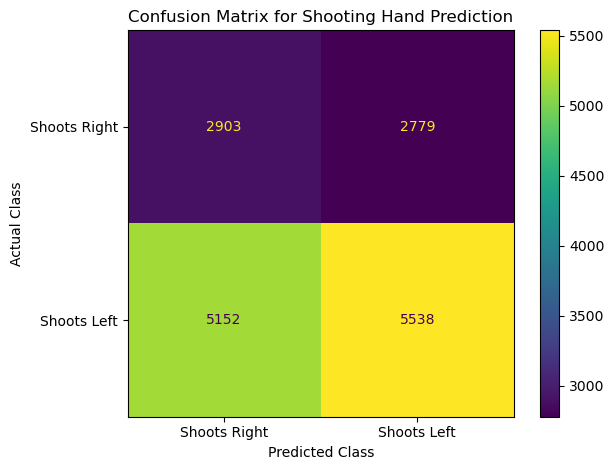

In [18]:
# Display confusion matrix for model performance on test set
cm = ConfusionMatrixDisplay.from_estimator(
    logreg,
    X_test,
    y_test,
    values_format="d",
)

# Modify tick labels
cm.ax_.set_xticklabels(["Shoots Right", "Shoots Left"])
cm.ax_.set_yticklabels(["Shoots Right", "Shoots Left"])

# Add a title and axis labels
cm.ax_.set_title("Confusion Matrix for Shooting Hand Prediction")
cm.ax_.set_xlabel("Predicted Class")
cm.ax_.set_ylabel("Actual Class")

# Display the plot
cm.figure_.tight_layout()  

Figure 2. Confusion matrix for model performance on test set

# Discussion

###  What we found?  
The logistic regression model yielded a weak correlation between an NHL player’s height and weight and their shooting hand. The model’s accuracy score on the test set was 0.51, barely above random guessing.  

### Is this what we expected to find?  
Given the complexity of human physical attributes and their possible influences on preferences, it was somewhat expected that height and weight alone would not be strong predictors of shooting hand. Shooting hand preference could be influenced by various factors, such as handedness, training, or cultural norms, which are not captured by the dataset.

### What impact could such findings have?  
These findings suggest that physical attributes like height and weight are not sufficient for predicting shooting hand. This highlights the importance of exploring additional features such as handedness, training history, or team strategy. For NHL teams, relying solely on height and weight for such predictions would not be effective for player scouting or strategy optimization.

### What future questions could this lead to?  
- What additional features (e.g., handedness, practice hours, family handedness trends) could improve the prediction of shooting hand?  
- How do environmental or cultural factors influence shooting hand preference?  
- Are there relationships between shooting hand and performance metrics, such as goals scored or defensive success?  
- Can machine learning models combining multiple physical and behavioral attributes provide better predictions?  

# References

Data Science Learning Community. (2024). NHL rosters dataset. Tidy Tuesday project repository. https://github.com/rfordatascience/tidytuesday/blob/master/data/2024/2024-01-09/nhl_rosters.csv

Python Software Foundation. (n.d.). Python programming language. https://www.python.org/

The pandas development team. (n.d.). Pandas: Powerful Python data analysis toolkit. https://pandas.pydata.org/

VanderPlas, J., et al. (n.d.). Altair: Declarative statistical visualization library for Python. https://altair-viz.github.io/

Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., Blondel, M., Prettenhofer, P., Weiss, R., Dubourg, V., Vanderplas, J., Passos, A., Cournapeau, D., Brucher, M., Perrot, M., & Duchesnay, E. (2011). Scikit-learn: Machine learning in Python. Journal of Machine Learning Research, 12, 2825–2830. https://www.jmlr.org/papers/volume12/pedregosa11a/pedregosa11a.pdf